# cLSTM Lorenz-96 Demo
- In this notebook, we train a cLSTM model on data simulated from a Lorenz-96 system

In [2]:
import os
os.chdir("/project/lcd_v2")
import sys
sys.path.append('/project/lcd_v2/run')
import torch
import numpy as np
import matplotlib.pyplot as plt
from external.Neural_GC.synthetic import simulate_lorenz_96
from external.Neural_GC.models.clstm import cLSTM, train_model_ista

In [6]:
# For GPU acceleration
device = torch.device('cuda')

In [7]:
# Simulate data
X_np, GC = simulate_lorenz_96(p=10, F=10, T=1000)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=device)

In [8]:
X.shape

torch.Size([1, 1000, 10])

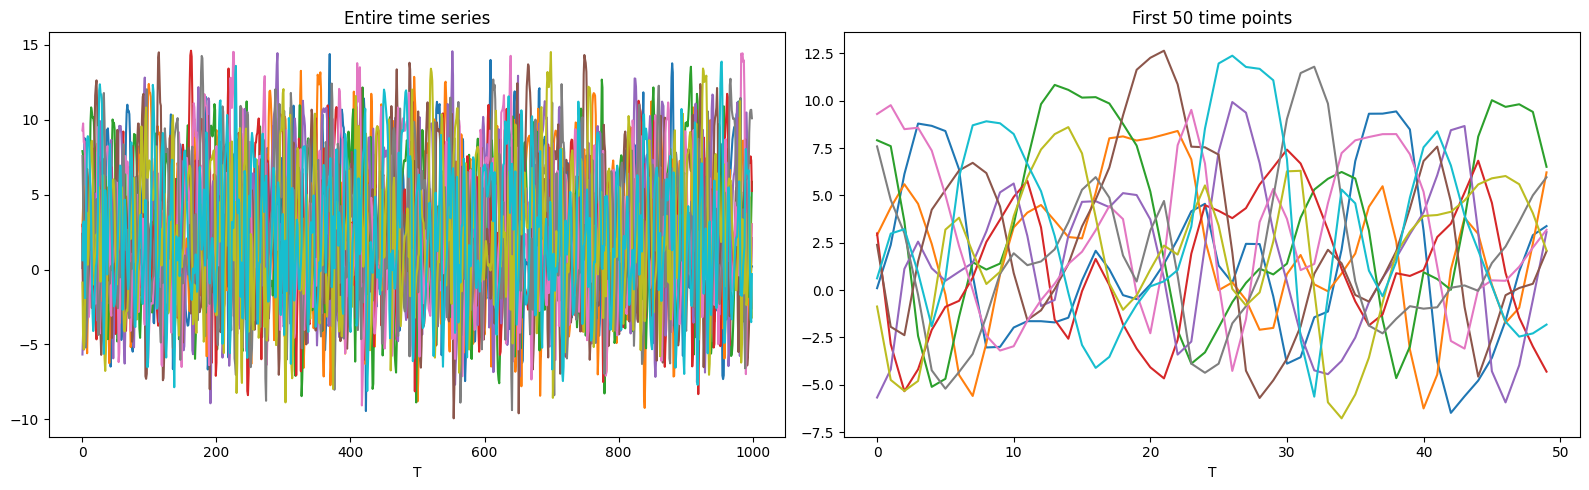

In [9]:
# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(X_np)
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[1].plot(X_np[:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
plt.tight_layout()
plt.show()

In [10]:
# Set up model
clstm = cLSTM(X.shape[-1], hidden=100).cuda(device=device)

In [6]:
# Train with ISTA
train_loss_list = train_model_ista(
    clstm, X, context=10, lam=10.0, lam_ridge=1e-2, lr=1e-3, max_iter=20000,
    check_every=50)

----------Iter = 50----------
Loss = 86.022339
Variable usage = 100.00%
----------Iter = 100----------
Loss = 37.665813
Variable usage = 100.00%
----------Iter = 150----------
Loss = 21.818947
Variable usage = 23.00%
----------Iter = 200----------
Loss = 20.417952
Variable usage = 17.00%
----------Iter = 250----------
Loss = 19.593435
Variable usage = 15.00%
----------Iter = 300----------
Loss = 19.035263
Variable usage = 14.00%
----------Iter = 350----------
Loss = 18.623486
Variable usage = 14.00%
----------Iter = 400----------
Loss = 18.295462
Variable usage = 17.00%
----------Iter = 450----------
Loss = 18.012493
Variable usage = 20.00%
----------Iter = 500----------
Loss = 17.752266
Variable usage = 24.00%
----------Iter = 550----------
Loss = 17.504141
Variable usage = 27.00%
----------Iter = 600----------
Loss = 17.263535
Variable usage = 27.00%
----------Iter = 650----------
Loss = 17.029465
Variable usage = 29.00%
----------Iter = 700----------
Loss = 16.801672
Variable usage 

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

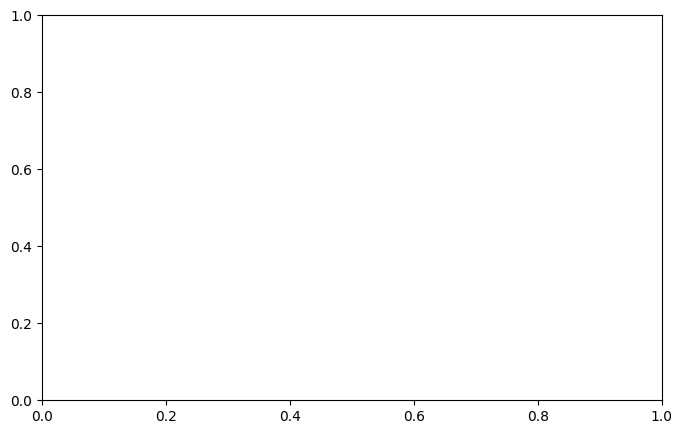

In [12]:
# Loss function plot
plt.figure(figsize=(8, 5))
plt.plot(50 * np.arange(len(train_loss_list)), train_loss_list)
plt.title('cLSTM training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.tight_layout()
plt.show()

True variable usage = 40.00%
Estimated variable usage = 41.00%
Accuracy = 97.00%


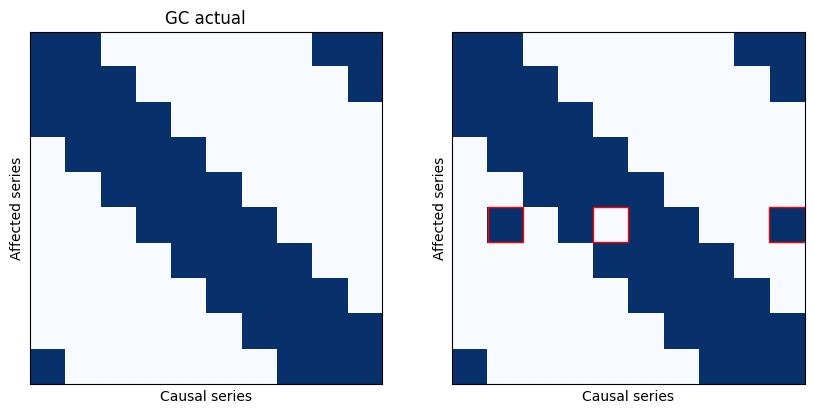

In [13]:
# Check learned Granger causality
GC_est = clstm.GC().cpu().data.numpy()

print('True variable usage = %.2f%%' % (100 * np.mean(GC)))
print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))
print('Accuracy = %.2f%%' % (100 * np.mean(GC == GC_est)))

# Make figures
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
axarr[0].imshow(GC, cmap='Blues')
axarr[0].set_title('GC actual')
axarr[0].set_ylabel('Affected series')
axarr[0].set_xlabel('Causal series')
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0))
axarr[1].set_ylabel('Affected series')
axarr[1].set_xlabel('Causal series')
axarr[1].set_xticks([])
axarr[1].set_yticks([])

# Mark disagreements
for i in range(len(GC_est)):
    for j in range(len(GC_est)):
        if GC[i, j] != GC_est[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

plt.show()